In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
from datetime import datetime
import os

from algorithms import *
from fairness import *
from preferences import *

from scipy.stats import truncnorm
from scipy.stats import pareto
from scipy.stats import norm


In this section, we provide empirical data for the results of Lemma 4.1.

<Figure size 640x480 with 0 Axes>

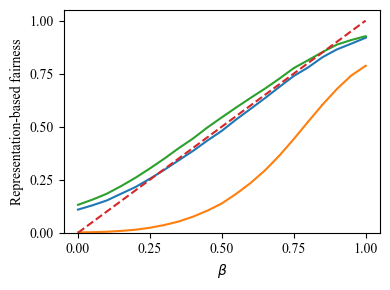

<Figure size 640x480 with 0 Axes>

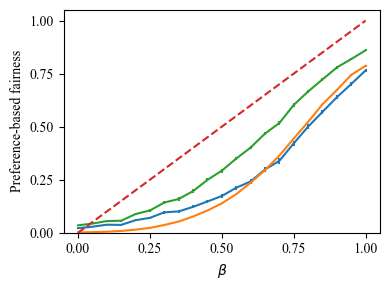

<Figure size 640x480 with 0 Axes>

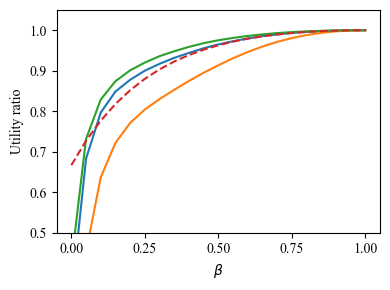

In [6]:
n = 10000
p = 5
cut = n // 2 # Both groups have 500
k = [1000] * p # We consider where 1/2 are selected
type = 'r'
std = 0.1
# dist = 'uniform'

uniform_r_means, uniform_p_means, uniform_u_means = [], [], []
uniform_r_sems, uniform_p_sems, uniform_u_sems = [], [], []

pareto_r_means, pareto_p_means, pareto_u_means = [], [], []
pareto_r_sems, pareto_p_sems, pareto_u_sems = [], [], []

gaussian_r_means, gaussian_p_means, gaussian_u_means = [], [], []
gaussian_r_sems, gaussian_p_sems, gaussian_u_sems = [], [], []

# We iterate oevr beta in increments of 0.05
betas = np.linspace(0, 1, 21)
for beta in betas:
    if beta == 0:
        beta = 0.00000000000001
    uniform_r_res, uniform_p_res, uniform_u_res = [], [], []
    pareto_r_res, pareto_p_res, pareto_u_res = [], [], []
    gaussian_r_res, gaussian_p_res, gaussian_u_res = [], [], []
    # Run 50 iterations
    for i in range(50):
        # print(f"{i}")
        # Generate utilities over Unif(0,1)
        uniform_utils = np.random.rand(n)
        pareto_utils = pareto.rvs(b = 3, size = n)
        gaussian_utils = truncnorm.rvs(a = 0, b = np.inf, size = n)
        # print(latent_utils)


        if std != 0:
                lower, upper = 0, 1
                a, b = (lower - beta) / std, (upper - beta) / std

                beta_dist = truncnorm.rvs(a, b, loc=beta, scale=std, size=n-cut)
        else:
            beta_dist = [beta] * n

        # Beta bias
        uniform_est_utils = uniform_utils[::]
        uniform_est_utils[cut:] = beta_dist * uniform_est_utils[cut:]
    
        pareto_est_utils = pareto_utils[::]
        pareto_est_utils[cut:] = beta_dist * pareto_est_utils[cut:]

        gaussian_est_utils = gaussian_utils[::]
        gaussian_est_utils[cut:] = beta_dist * gaussian_est_utils[cut:]
        # print(est_utils)

        # Preferences, randomly generated
        # preferences = [np.random.permutation(p) for _ in range(n)]
        preferences = generate_mallows_preferences(n, p, 0, 0.25)

        # Run unconstrained algorithm (unique stable matching)
        uniform_res = gale_shapley(S=range(n), k=k[::], sigma=preferences, est_util=uniform_est_utils)
        pareto_res = gale_shapley(S=range(n), k=k[::], sigma=preferences, est_util=pareto_est_utils)
        gaussian_res = gale_shapley(S=range(n), k=k[::], sigma=preferences, est_util=gaussian_est_utils)
        # print(iter_res)
        

        # Calculate R, P, and U
        # R: proportion of the number of agents that is assigned to an institution / other
        uniform_a_res = sum([0 if x == -1 else 1 for x in uniform_res[:cut]]) / cut
        uniform_b_res = sum([0 if x == -1 else 1 for x in uniform_res[cut:]]) / (n - cut)
        uniform_r_iter = uniform_b_res / uniform_a_res

        pareto_a_res = sum([0 if x == -1 else 1 for x in pareto_res[:cut]]) / cut
        pareto_b_res = sum([0 if x == -1 else 1 for x in pareto_res[cut:]]) / (n - cut)
        pareto_r_iter = pareto_b_res / pareto_a_res

        gaussian_a_res = sum([0 if x == -1 else 1 for x in gaussian_res[:cut]]) / cut
        gaussian_b_res = sum([0 if x == -1 else 1 for x in gaussian_res[cut:]]) / (n - cut)
        gaussian_r_iter = gaussian_b_res / gaussian_a_res

        #if r_iter > 1:
        #    r_iter = 1 / r_iter
        
        uniform_r_res.append(uniform_r_iter)
        pareto_r_res.append(pareto_r_iter)
        gaussian_r_res.append(gaussian_r_iter)

        # P: calculate ptop1 (P <= R for all p, because R is P with weighting index [0 0 ... 1])
        uniform_p_res.append(ptop1(uniform_res, preferences, cut))
        pareto_p_res.append(ptop1(pareto_res, preferences, cut))
        gaussian_p_res.append(ptop1(gaussian_res, preferences, cut))

        # U: calculate U
        uniform_u_res.append(u(results=uniform_res, utilities=uniform_utils, cut=cut, beta=beta))
        pareto_u_res.append(u(results=pareto_res, utilities=pareto_utils, cut=cut, beta=beta))
        gaussian_u_res.append(u(results=gaussian_res, utilities=gaussian_utils, cut=cut, beta=beta))
    
    uniform_r_means.append(sum(uniform_r_res)/len(uniform_r_res))
    uniform_p_means.append(sum(uniform_p_res)/len(uniform_p_res))
    uniform_u_means.append(sum(uniform_u_res)/len(uniform_u_res))
    uniform_r_sems.append(np.std(uniform_r_res)/np.sqrt(len(uniform_r_res)))
    uniform_p_sems.append(np.std(uniform_p_res)/np.sqrt(len(uniform_p_res)))
    uniform_u_sems.append(np.std(uniform_u_res)/np.sqrt(len(uniform_u_res)))

    pareto_r_means.append(sum(pareto_r_res)/len(pareto_r_res))
    pareto_p_means.append(sum(pareto_p_res)/len(pareto_p_res))
    pareto_u_means.append(sum(pareto_u_res)/len(pareto_u_res))
    pareto_r_sems.append(np.std(pareto_r_res)/np.sqrt(len(pareto_r_res)))
    pareto_p_sems.append(np.std(pareto_p_res)/np.sqrt(len(pareto_p_res)))
    pareto_u_sems.append(np.std(pareto_u_res)/np.sqrt(len(pareto_u_res)))

    gaussian_r_means.append(sum(gaussian_r_res)/len(gaussian_r_res))
    gaussian_p_means.append(sum(gaussian_p_res)/len(gaussian_p_res))
    gaussian_u_means.append(sum(gaussian_u_res)/len(gaussian_u_res))
    gaussian_r_sems.append(np.std(gaussian_r_res)/np.sqrt(len(gaussian_r_res)))
    gaussian_p_sems.append(np.std(gaussian_p_res)/np.sqrt(len(gaussian_p_res)))
    gaussian_u_sems.append(np.std(gaussian_u_res)/np.sqrt(len(gaussian_u_res)))

# print(u_means)
# print(u_sems)
    
# PLOT FOR R
plt.figure().clear() 
plt.figure().set_size_inches(4, 3, forward=True)
    # plt.figure().set_figheight(2)
    # plt.figure().set_figwidth(4)
    
    # plt.margins(0.1)

plt.errorbar(betas, uniform_r_means, yerr=uniform_r_sems, fmt='-', label='Uniform')
plt.errorbar(betas, pareto_r_means, yerr=pareto_r_sems, fmt='-', label='Pareto')
plt.errorbar(betas, gaussian_r_means, yerr=gaussian_r_sems, fmt='-', label='Gaussian')
plt.errorbar(betas, betas, yerr=0, fmt='--', label='Theoretical')
plt.ylabel("Representation-based fairness")
plt.xlabel(r'$\beta$')

plt.ylim(0, 1.05)
plt.yticks(np.arange(0, 1.05, 0.25))
plt.xticks(np.arange(0, 1.05, 0.25))

plt.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'gsbounds4-1_r_all_std{std}.png')
plt.savefig(filename)


# PLOT FOR P
plt.figure().clear() 
plt.figure().set_size_inches(4, 3, forward=True)
    # plt.figure().set_figheight(2)
    # plt.figure().set_figwidth(4)
    
    # plt.margins(0.1)

plt.errorbar(betas, uniform_p_means, yerr=uniform_p_sems, fmt='-', label='Uniform')
plt.errorbar(betas, pareto_p_means, yerr=pareto_p_sems, fmt='-', label='Pareto')
plt.errorbar(betas, gaussian_p_means, yerr=gaussian_p_sems, fmt='-', label='Gaussian')
plt.errorbar(betas, betas, yerr=0, fmt='--', label='Theoretical (upper bound)')
plt.ylabel("Preference-based fairness")
plt.xlabel(r'$\beta$')

plt.ylim(0, 1.05)
plt.yticks(np.arange(0, 1.05, 0.25))
plt.xticks(np.arange(0, 1.05, 0.25))

plt.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'gsbounds4-1_p_all_std{std}.png')
plt.savefig(filename)


# PLOT FOR U
plt.figure().clear() 
plt.figure().set_size_inches(4, 3, forward=True)
    # plt.figure().set_figheight(2)
    # plt.figure().set_figwidth(4)
    
    # plt.margins(0.1)

u_est = [(2 * (x * x + 1 + 4 * x)) / (3 * (x + 1) * (x + 1)) for x in betas]
plt.errorbar(betas, uniform_u_means, yerr=uniform_u_sems, fmt='-', label='Uniform')
plt.errorbar(betas, pareto_u_means, yerr=pareto_u_sems, fmt='-', label='Pareto')
plt.errorbar(betas, gaussian_u_means, yerr=gaussian_u_sems, fmt='-', label='Gaussian')
plt.errorbar(betas, u_est, yerr=0, fmt='--', label='Theoretical')
plt.ylabel("Utility ratio")
plt.xlabel(r'$\beta$')

# plt.legend()

plt.ylim(0.5, 1.05)
plt.yticks(np.arange(0.5, 1.02, 0.1))
plt.xticks(np.arange(0, 1.05, 0.25))

plt.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'gsbounds4-1_u_all_std{std}.png')
plt.savefig(filename)



<Figure size 640x480 with 0 Axes>

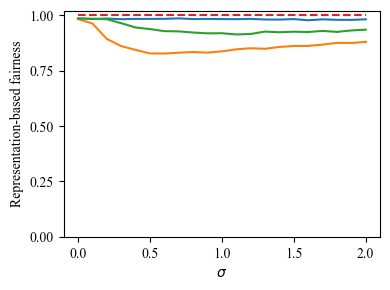

<Figure size 640x480 with 0 Axes>

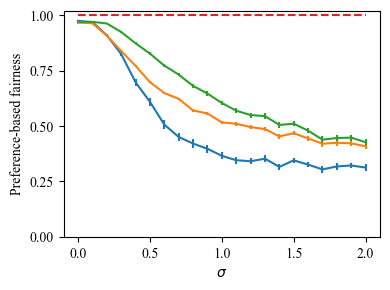

<Figure size 640x480 with 0 Axes>

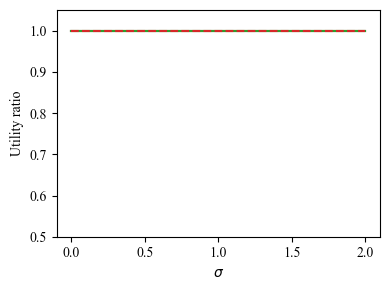

In [9]:
# IMPLICIT VARIANCE

n = 10000
p = 5
cut = n // 2 # Both groups have 500
k = [1000] * p # We consider where 1/2 are selected
type = 'r'
beta = 1
std = 0
# dist = 'uniform'

uniform_r_means, uniform_p_means, uniform_u_means = [], [], []
uniform_r_sems, uniform_p_sems, uniform_u_sems = [], [], []

pareto_r_means, pareto_p_means, pareto_u_means = [], [], []
pareto_r_sems, pareto_p_sems, pareto_u_sems = [], [], []

gaussian_r_means, gaussian_p_means, gaussian_u_means = [], [], []
gaussian_r_sems, gaussian_p_sems, gaussian_u_sems = [], [], []


sigmas = np.linspace(0, 2, 21)
for sigma in sigmas:
    uniform_r_res, uniform_p_res, uniform_u_res = [], [], []
    pareto_r_res, pareto_p_res, pareto_u_res = [], [], []
    gaussian_r_res, gaussian_p_res, gaussian_u_res = [], [], []
    # Run 50 iterations
    for i in range(50):
        # print(f"{i}")
        # Generate utilities over Unif(0,1)
        uniform_utils = np.random.rand(n)
        pareto_utils = pareto.rvs(b = 3, size = n)
        gaussian_utils = truncnorm.rvs(a = 0, b = np.inf, size = n)
        # print(latent_utils)

        # Beta bias
        uniform_est_utils = uniform_utils[::]
        # uniform_est_utils[cut:] = uniform_est_utils[cut:]
    
        pareto_est_utils = pareto_utils[::]
        # pareto_est_utils[cut:] = pareto_est_utils[cut:]

        gaussian_est_utils = gaussian_utils[::]
        # gaussian_est_utils[cut:] = gaussian_est_utils[cut:]

        if sigma > 0:
            # noise_beta = truncnorm.rvs(a=0, b=np.inf, size = len(utils_beta))
            noise_uniform = norm.rvs(0, 1, n-cut)
            noise_uniform = noise_uniform * sigma
            uniform_est_utils[cut:] = np.add(uniform_est_utils[cut:], noise_uniform)

            noise_pareto = norm.rvs(0, 1, n-cut)
            noise_pareto = noise_pareto * sigma
            pareto_est_utils[cut:] = np.add(pareto_est_utils[cut:], noise_pareto)

            noise_gaussian = norm.rvs(0, 1, n-cut)
            noise_gaussian = noise_gaussian * sigma
            gaussian_est_utils[cut:] = np.add(gaussian_est_utils[cut:], noise_gaussian)

        # print(est_utils)

        # Preferences, randomly generated
        # preferences = [np.random.permutation(p) for _ in range(n)]
        preferences = generate_mallows_preferences(n, p, 0, 0.25)

        # Run unconstrained algorithm (unique stable matching)
        uniform_res = gale_shapley(S=range(n), k=k[::], sigma=preferences, est_util=uniform_est_utils)
        pareto_res = gale_shapley(S=range(n), k=k[::], sigma=preferences, est_util=pareto_est_utils)
        gaussian_res = gale_shapley(S=range(n), k=k[::], sigma=preferences, est_util=gaussian_est_utils)
        # print(iter_res)
        

        # Calculate R, P, and U
        # R: proportion of the number of agents that is assigned to an institution / other
        uniform_a_res = sum([0 if x == -1 else 1 for x in uniform_res[:cut]]) / cut
        uniform_b_res = sum([0 if x == -1 else 1 for x in uniform_res[cut:]]) / (n - cut)
        uniform_r_iter = uniform_b_res / uniform_a_res
        uniform_r_iter = min(uniform_r_iter, 1 / uniform_r_iter)

        pareto_a_res = sum([0 if x == -1 else 1 for x in pareto_res[:cut]]) / cut
        pareto_b_res = sum([0 if x == -1 else 1 for x in pareto_res[cut:]]) / (n - cut)
        pareto_r_iter = pareto_b_res / pareto_a_res
        pareto_r_iter = min(pareto_r_iter, 1 / pareto_r_iter)

        gaussian_a_res = sum([0 if x == -1 else 1 for x in gaussian_res[:cut]]) / cut
        gaussian_b_res = sum([0 if x == -1 else 1 for x in gaussian_res[cut:]]) / (n - cut)
        gaussian_r_iter = gaussian_b_res / gaussian_a_res
        gaussian_r_iter = min(gaussian_r_iter, 1 / gaussian_r_iter)

        #if r_iter > 1:
        #    r_iter = 1 / r_iter
        
        uniform_r_res.append(uniform_r_iter)
        pareto_r_res.append(pareto_r_iter)
        gaussian_r_res.append(gaussian_r_iter)

        # P: calculate ptop1 (P <= R for all p, because R is P with weighting index [0 0 ... 1])
        uniform_p_res.append(ptop1(uniform_res, preferences, cut))
        pareto_p_res.append(ptop1(pareto_res, preferences, cut))
        gaussian_p_res.append(ptop1(gaussian_res, preferences, cut))

        # U: calculate U
        uniform_u_res.append(u(results=uniform_res, utilities=uniform_utils, cut=cut, beta=beta))
        pareto_u_res.append(u(results=pareto_res, utilities=pareto_utils, cut=cut, beta=beta))
        gaussian_u_res.append(u(results=gaussian_res, utilities=gaussian_utils, cut=cut, beta=beta))
    
    uniform_r_means.append(sum(uniform_r_res)/len(uniform_r_res))
    uniform_p_means.append(sum(uniform_p_res)/len(uniform_p_res))
    uniform_u_means.append(sum(uniform_u_res)/len(uniform_u_res))
    uniform_r_sems.append(np.std(uniform_r_res)/np.sqrt(len(uniform_r_res)))
    uniform_p_sems.append(np.std(uniform_p_res)/np.sqrt(len(uniform_p_res)))
    uniform_u_sems.append(np.std(uniform_u_res)/np.sqrt(len(uniform_u_res)))

    pareto_r_means.append(sum(pareto_r_res)/len(pareto_r_res))
    pareto_p_means.append(sum(pareto_p_res)/len(pareto_p_res))
    pareto_u_means.append(sum(pareto_u_res)/len(pareto_u_res))
    pareto_r_sems.append(np.std(pareto_r_res)/np.sqrt(len(pareto_r_res)))
    pareto_p_sems.append(np.std(pareto_p_res)/np.sqrt(len(pareto_p_res)))
    pareto_u_sems.append(np.std(pareto_u_res)/np.sqrt(len(pareto_u_res)))

    gaussian_r_means.append(sum(gaussian_r_res)/len(gaussian_r_res))
    gaussian_p_means.append(sum(gaussian_p_res)/len(gaussian_p_res))
    gaussian_u_means.append(sum(gaussian_u_res)/len(gaussian_u_res))
    gaussian_r_sems.append(np.std(gaussian_r_res)/np.sqrt(len(gaussian_r_res)))
    gaussian_p_sems.append(np.std(gaussian_p_res)/np.sqrt(len(gaussian_p_res)))
    gaussian_u_sems.append(np.std(gaussian_u_res)/np.sqrt(len(gaussian_u_res)))

# print(u_means)
# print(u_sems)
    
# PLOT FOR R
plt.figure().clear() 
plt.figure().set_size_inches(4, 3, forward=True)
    # plt.figure().set_figheight(2)
    # plt.figure().set_figwidth(4)
    
    # plt.margins(0.1)

plt.errorbar(sigmas, uniform_r_means, yerr=uniform_r_sems, fmt='-', label='Uniform')
plt.errorbar(sigmas, pareto_r_means, yerr=pareto_r_sems, fmt='-', label='Pareto')
plt.errorbar(sigmas, gaussian_r_means, yerr=gaussian_r_sems, fmt='-', label='Gaussian')
plt.errorbar(sigmas, [1] * 21, yerr=0, fmt='--', label='Theoretical')
plt.ylabel("Representation-based fairness")
plt.xlabel(r'$\sigma$')

# plt.legend()

plt.ylim(0, 1.02)
plt.yticks(np.arange(0, 1.05, 0.25))
plt.xticks(np.arange(0, 2.05, 0.5))

plt.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'gsbounds4-1_r_all_std{std}.png')
plt.savefig(filename)


# PLOT FOR P
plt.figure().clear() 
plt.figure().set_size_inches(4, 3, forward=True)
    # plt.figure().set_figheight(2)
    # plt.figure().set_figwidth(4)
    
    # plt.margins(0.1)

plt.errorbar(sigmas, uniform_p_means, yerr=uniform_p_sems, fmt='-', label='Uniform')
plt.errorbar(sigmas, pareto_p_means, yerr=pareto_p_sems, fmt='-', label='Pareto')
plt.errorbar(sigmas, gaussian_p_means, yerr=gaussian_p_sems, fmt='-', label='Gaussian')
plt.errorbar(sigmas, [1] * 21, yerr=0, fmt='--', label='Theoretical (upper bound)')
plt.ylabel("Preference-based fairness")
plt.xlabel(r'$\sigma$')

# plt.legend()

plt.ylim(0, 1.02)
plt.yticks(np.arange(0, 1.05, 0.25))
plt.xticks(np.arange(0, 2.05, 0.5))

plt.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'gsbounds4-1_p_all_std{std}.png')
plt.savefig(filename)


# PLOT FOR U
plt.figure().clear() 
plt.figure().set_size_inches(4, 3, forward=True)
    # plt.figure().set_figheight(2)
    # plt.figure().set_figwidth(4)
    
    # plt.margins(0.1)

u_est = [(2 * (x * x + 1 + 4 * x)) / (3 * (x + 1) * (x + 1)) for x in [1] * 21]
plt.errorbar(sigmas, uniform_u_means, yerr=uniform_u_sems, fmt='-', label='Uniform')
plt.errorbar(sigmas, pareto_u_means, yerr=pareto_u_sems, fmt='-', label='Pareto')
plt.errorbar(sigmas, gaussian_u_means, yerr=gaussian_u_sems, fmt='-', label='Gaussian')
plt.errorbar(sigmas, u_est, yerr=0, fmt='--', label='Theoretical')
plt.ylabel("Utility ratio")
plt.xlabel(r'$\sigma$')

# plt.legend()

plt.ylim(0.5, 1.05)
plt.yticks(np.arange(0.5, 1.02, 0.1))
plt.xticks(np.arange(0, 2.05, 0.5))

plt.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'gsbounds4-1_u_all_std{std}.png')
plt.savefig(filename)



/var/folders/kb/5c9mprws2r526ptjpxbt65v80000gn/T/ipykernel_1151/1272164834.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x50 with 0 Axes>

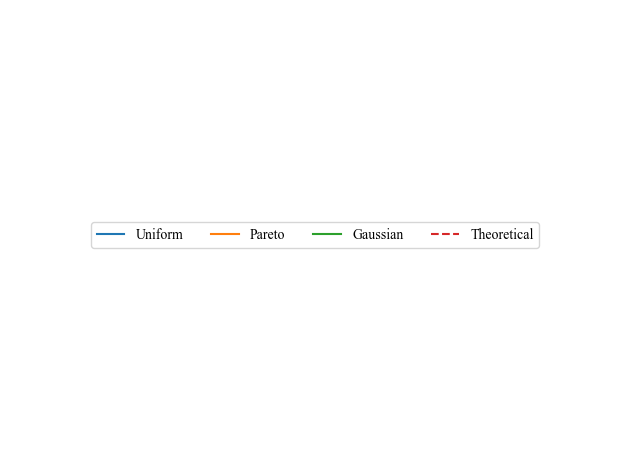

In [23]:
# Print legend

plt.figure().clear()
plt.figure().set_size_inches(3, 0.5, forward=True)


# Create figure and axis
fig, ax = plt.subplots()

# Plot empty data with desired legend labels
ax.plot([], [], '-', label='Uniform')
ax.plot([], [], '-', label='Pareto')
ax.plot([], [], '-', label='Gaussian')
ax.plot([], [], '--', label='Theoretical')

# Create horizontal legend with no white space except for margins
legend = ax.legend(loc='center', ncol=4, frameon=True)

# Remove axis lines and ticks
ax.axis('off')

# Tight layout to minimize white space
fig.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'gsbounds_legend.png')
fig.savefig(filename)

# Show only the legend
fig.show()


/var/folders/kb/5c9mprws2r526ptjpxbt65v80000gn/T/ipykernel_3171/3354190396.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x50 with 0 Axes>

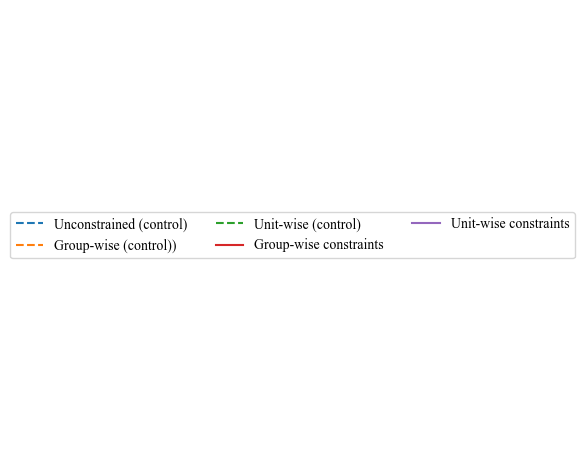

In [8]:
plt.figure().clear()
plt.figure().set_size_inches(3, 0.5, forward=True)


# Create figure and axis
fig, ax = plt.subplots()

# Plot empty data with desired legend labels
ax.plot([], [], '--', label='Unconstrained (control)')
ax.plot([], [], '--', label='Group-wise (control))')
ax.plot([], [], '--', label='Unit-wise (control)')
ax.plot([], [], '-', label='Group-wise constraints')
ax.plot([], [], '-', label='Unit-wise constraints')

# Create horizontal legend with no white space except for margins
legend = ax.legend(loc='center', ncol=3, frameon=True)

# Remove axis lines and ticks
ax.axis('off')

# Tight layout to minimize white space
fig.tight_layout()

current_date = datetime.now().strftime('%m-%d-%Y')
subdirectory = os.path.join('plots', current_date)
os.makedirs(subdirectory, exist_ok=True)

filename = os.path.join(subdirectory, f'relaxedbounds_legend.png')
fig.savefig(filename)

# Show only the legend
fig.show()